In [15]:
#import required libraries 
%matplotlib inline
import geopandas as gpd 
import rasterio 
from rasterio.enums import Resampling
from rasterio.plot import show 
import matplotlib.pyplot as plt
import shutil
import xarray as xr
from odc.algo import xr_reproject
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from datacube.testutils.io import rio_slurp_xarray
from odc.algo import xr_reproject

In [16]:
LCCS = xr.open_rasterio('..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif')
InSAR = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/20200303-20200309_coh.tif'))

In [17]:
# Load raster and reproject to match satellite InSAR
LCCS_reprojected = rio_slurp_xarray(fname='..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif',
                                      gbox=InSAR.geobox,
                                      resampling="mode")

In [18]:
print(LCCS_reprojected) #this layer needs to be devided by 1.7 scaling factor if we use the other approach

<xarray.DataArray (latitude: 965, longitude: 832)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * latitude     (latitude) float64 -24.79 -24.8 -24.8 ... -28.8 -28.8 -28.81
  * longitude    (longitude) float64 149.4 149.4 149.4 ... 152.9 152.9 152.9
    spatial_ref  int32 4326
Attributes:
    nodata:   0.0


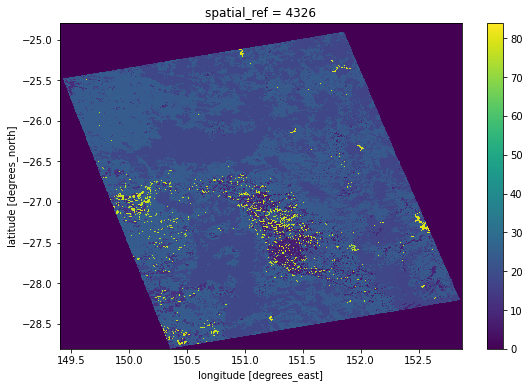

In [23]:
LCCS_reprojected.plot(size=6)

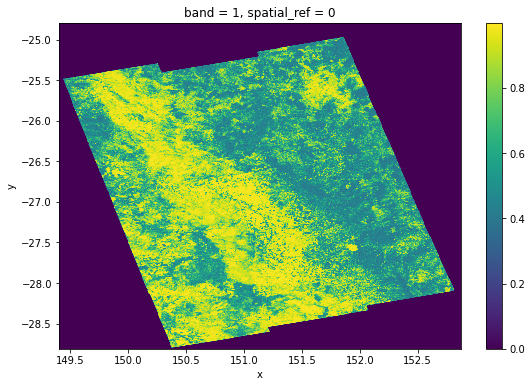

In [24]:
InSAR.plot(size=6)

In [26]:
write_cog(geo_im=LCCS_reprojected,
          fname='..//Real_world_examples/LCCSlayer/lccs_2015_450m.tif',
          overwrite=True)

PosixPath('../Real_world_examples/LCCSlayer/lccs_2015_450m.tif')

In [22]:
InSAR.geobox #width, height in pixel, Affine with spatial resolution and spatial position, and coordinate reference system 

GeoBox(832, 965, Affine(0.004166666700000004, 0.0, 149.40430581111,
       0.0, -0.004166666699999998, -24.79013911111), GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]])

In [24]:
InSAR.geobox.resolution   #InSAR.geobox.extent.boundingbox

(-0.004166666699999998, 0.004166666700000004)

In [26]:
LCCS_coarse = xr_reproject(src=LCCS,
                          geobox=InSAR.geobox,
                          resampling='mode')

In [ ]:
write_cog(LCCS_coarse)

In [51]:
#open the source file and grab metadata from original file 
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif') as src:
    metadata = src.profile
metadata['dtype'] = 'uint8'
metadata['transform'] = src.transform

In [53]:
downscale_factor = 10

In [54]:
#resample LCCS raster file to higher resolution 
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif') as dataset:
        #resample data to target shape
    data = dataset.read(out_shape=(dataset.count,
                                   int(dataset.height*downscale_factor),
                                   int(dataset.width*downscale_factor)),
                        resampling=Resampling.bilinear
    )
    #scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
#     transform[:6]
    metadata['transform'] = tuple(transform[:6])
#     print(tuple(transform))


In [55]:
metadata

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1148, 'height': 1643, 'count': 1, 'crs': CRS.from_epsg(3577), 'transform': (25.0, 0.0, 1727000.0, 0.0, -25.0, -2846250.0), 'tiled': False, 'interleave': 'band'}

In [29]:
print(dataset.shape)x

SyntaxError: invalid syntax (<ipython-input-29-10ed9a93093d>, line 1)

In [13]:
#a numpy array
print(data.shape)

(1, 2957, 2066)


In [56]:
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs-new2.tif','w',**metadata) as dst:
    dst.write(data)

In [15]:
data.metadata

AttributeError: 'numpy.ndarray' object has no attribute 'metadata'

In [175]:
#a numpy array
print(data.shape)

(1, 6572, 4592)


In [122]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint8'}

In [ ]:
#import shapefile of the points that are going to be sampled
#by plotting the point data crs and also your raster make sure that both are in the same coordinate system 
pointData = gpd.read_file('path to the shapefile')
print(pointData.crs)
pointData.plot();

In [ ]:
#Read and open the raster file that needs to be resampled 
#Land cover and Land use file 
LCCRaster = rasterio.open('path to the LCCS file')
print(LCCRaster.crs)
print(LCCRaster.count)
#InSAR coherence file 
# CohRaster = rasterio.open('path to the coherence file')
# print(CohRaster.crs)
# print(CohRaster.count)

In [ ]:
#showing both points and raster file in one plot 
fig, ax = plt.subplot(figsize=(12,12))
pointData.plot(ax=ax, color = 'orangered')
show(LCCRaster,ax=ax)

In [ ]:
#extract point geometry from the point shapefile
for point in pointData['geometry']:
    print(point.xy[0][0],point.xy[1][0])

In [ ]:
#extract raster values in each point location 
for point in pointData['geometry']:
    x = point.xy[0][0]
    y = point.xy[1][0]
    row,col = LCCRaster.index(x,y)
    print('Point corresponds to row,column: %d,%d'%(row,col))
    print('Raster value on point  %.2f \n'%(LCCRaster.read(1)[row,col])) #for single band raster 

In [ ]:
#the reference is here: https://www.youtube.com/watch?v=QhUcgOOsUy8